# US Stock Market Prediction using data based on a Window

In [1]:
# Importing necessary packages
import os
import numpy as np
import pandas as pd
import logging
import warnings
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import csv
import lightgbm as lgb

from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')

# Setting up logging with a FileHandler
log_file_path = 'logger_log.txt'
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

file_handler = logging.FileHandler(log_file_path)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

logger = logging.getLogger(__name__)
logger.addHandler(file_handler)

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
# Reading the dataset
dataset_path = "/kaggle/input/us-stock-market-2020-to-2024/US Stock Market Dataset.csv"

try:
    # Attempt to read the dataset
    df = pd.read_csv(dataset_path)
    logger.info(f"Dataset loaded successfully from {dataset_path}")
except FileNotFoundError:
    logger.error("Error: Dataset file not found. Please provide the correct file path.")
except Exception as e:
    logger.error(f"An error occurred: {e}")
    
# Rename the first column
df = df.rename(columns={df.columns[0]: 'date_index'})
print(df.columns)

df = df[['date_index','Natural_Gas_Price','Natural_Gas_Vol.','Crude_oil_Price', 'Crude_oil_Vol.', 'Copper_Price'     ]]
df['prev_index'] = df['date_index'] + 1
df.head(5)

Index(['date_index', 'Date', 'Natural_Gas_Price', 'Natural_Gas_Vol.',
       'Crude_oil_Price', 'Crude_oil_Vol.', 'Copper_Price', 'Copper_Vol.',
       'Bitcoin_Price', 'Bitcoin_Vol.', 'Platinum_Price', 'Platinum_Vol.',
       'Ethereum_Price', 'Ethereum_Vol.', 'S&P_500_Price', 'Nasdaq_100_Price',
       'Nasdaq_100_Vol.', 'Apple_Price', 'Apple_Vol.', 'Tesla_Price',
       'Tesla_Vol.', 'Microsoft_Price', 'Microsoft_Vol.', 'Silver_Price',
       'Silver_Vol.', 'Google_Price', 'Google_Vol.', 'Nvidia_Price',
       'Nvidia_Vol.', 'Berkshire_Price', 'Berkshire_Vol.', 'Netflix_Price',
       'Netflix_Vol.', 'Amazon_Price', 'Amazon_Vol.', 'Meta_Price',
       'Meta_Vol.', 'Gold_Price', 'Gold_Vol.'],
      dtype='object')


,date_index,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,prev_index
0,0,2.079,NaN,72.28,NaN,3.8215,1
1,1,2.050,161340.0,73.82,577940.0,3.8535,2
2,2,2.100,142860.0,75.85,344490.0,3.9060,3
3,3,2.077,139750.0,77.82,347240.0,3.9110,4
4,4,2.490,3590.0,76.78,331930.0,3.8790,5


In [3]:
def get_prev_pane(df,y,index_col):
    df['prev_index'] = df[index_col] + y
    column_names = df.columns
    df_tmp = pd.merge(df, df, left_on=index_col, right_on='prev_index', how='inner', suffixes=("_"+str(y),''))
    df_tmp = df_tmp.drop(column_names,axis=1)
    df_tmp = df_tmp.drop(['prev_index'+"_"+str(y),index_col+"_"+str(y)],axis=1)
    return df_tmp

In [4]:
window_back = 70

for i in range (0,window_back,1):
    prev_df = get_prev_pane(df,i,'date_index')
    if i == 0:
        final_df = prev_df
    else:
        final_df = pd.merge(final_df, prev_df, left_index=True, right_index=True)
    
final_df = final_df.iloc[:-window_back]
final_df

,Natural_Gas_Price_0,Natural_Gas_Vol._0,Crude_oil_Price_0,Crude_oil_Vol._0,Copper_Price_0,Natural_Gas_Price_1,Natural_Gas_Vol._1,Crude_oil_Price_1,Crude_oil_Vol._1,Copper_Price_1,...,Natural_Gas_Price_68,Natural_Gas_Vol._68,Crude_oil_Price_68,Crude_oil_Vol._68,Copper_Price_68,Natural_Gas_Price_69,Natural_Gas_Vol._69,Crude_oil_Price_69,Crude_oil_Vol._69,Copper_Price_69
0,2.079,NaN,72.28,NaN,3.8215,2.050,161340.0,73.82,577940.0,3.8535,...,3.010,31460.0,85.39,429460.0,3.5910,2.971,65430.0,83.74,370590.0,3.6240
1,2.050,161340.0,73.82,577940.0,3.8535,2.100,142860.0,75.85,344490.0,3.9060,...,2.971,65430.0,83.74,370590.0,3.6240,2.926,99130.0,85.49,315520.0,3.5865
2,2.100,142860.0,75.85,344490.0,3.9060,2.077,139750.0,77.82,347240.0,3.9110,...,2.926,99130.0,85.49,315520.0,3.5865,2.899,144040.0,88.75,27310.0,3.5630
3,2.077,139750.0,77.82,347240.0,3.9110,2.490,3590.0,76.78,331930.0,3.8790,...,2.899,144040.0,88.75,27310.0,3.5630,2.957,138650.0,89.37,72060.0,3.6010
4,2.490,3590.0,76.78,331930.0,3.8790,2.712,73020.0,78.01,365460.0,3.8520,...,2.957,138650.0,89.37,72060.0,3.6010,3.056,122850.0,88.32,92800.0,3.5870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869,1.829,165710.0,39.92,487330.0,2.9220,1.854,4060.0,41.27,295860.0,2.9190,...,1.821,283420.0,10.01,18440.0,2.2490,1.924,229820.0,-37.63,247950.0,2.3280
870,1.854,4060.0,41.27,295860.0,2.9190,1.800,32530.0,41.04,276800.0,2.9175,...,1.924,229820.0,-37.63,247950.0,2.3280,1.753,196980.0,18.27,240630.0,2.3540
871,1.800,32530.0,41.04,276800.0,2.9175,1.734,37480.0,41.60,377710.0,2.8975,...,1.753,196980.0,18.27,240630.0,2.3540,1.686,235590.0,19.87,350940.0,2.3020
872,1.734,37480.0,41.60,377710.0,2.8975,1.808,71800.0,41.29,353160.0,2.8925,...,1.686,235590.0,19.87,350940.0,2.3020,1.598,152700.0,19.87,544800.0,2.3040


In [5]:
col_names = final_df.columns[1:].tolist()
print(col_names)

# creating a copy of df
df1 = final_df.fillna(0)

#target column name
label_name = 'Natural_Gas_Price_0'

# defining the features and target
X = df1.drop([label_name],axis=1)
y = df1[[label_name]]

# instantiating the scaler
scaler = RobustScaler()

# scaling the continuous featuree
X[col_names] = scaler.fit_transform(X[col_names])

# Get centering and scaling values for each feature
centering = scaler.center_
iqrs  = scaler.scale_

X.head()

['Natural_Gas_Vol._0', 'Crude_oil_Price_0', 'Crude_oil_Vol._0', 'Copper_Price_0', 'Natural_Gas_Price_1', 'Natural_Gas_Vol._1', 'Crude_oil_Price_1', 'Crude_oil_Vol._1', 'Copper_Price_1', 'Natural_Gas_Price_2', 'Natural_Gas_Vol._2', 'Crude_oil_Price_2', 'Crude_oil_Vol._2', 'Copper_Price_2', 'Natural_Gas_Price_3', 'Natural_Gas_Vol._3', 'Crude_oil_Price_3', 'Crude_oil_Vol._3', 'Copper_Price_3', 'Natural_Gas_Price_4', 'Natural_Gas_Vol._4', 'Crude_oil_Price_4', 'Crude_oil_Vol._4', 'Copper_Price_4', 'Natural_Gas_Price_5', 'Natural_Gas_Vol._5', 'Crude_oil_Price_5', 'Crude_oil_Vol._5', 'Copper_Price_5', 'Natural_Gas_Price_6', 'Natural_Gas_Vol._6', 'Crude_oil_Price_6', 'Crude_oil_Vol._6', 'Copper_Price_6', 'Natural_Gas_Price_7', 'Natural_Gas_Vol._7', 'Crude_oil_Price_7', 'Crude_oil_Vol._7', 'Copper_Price_7', 'Natural_Gas_Price_8', 'Natural_Gas_Vol._8', 'Crude_oil_Price_8', 'Crude_oil_Vol._8', 'Copper_Price_8', 'Natural_Gas_Price_9', 'Natural_Gas_Vol._9', 'Crude_oil_Price_9', 'Crude_oil_Vol._9', 

,Natural_Gas_Vol._0,Crude_oil_Price_0,Crude_oil_Vol._0,Copper_Price_0,Natural_Gas_Price_1,Natural_Gas_Vol._1,Crude_oil_Price_1,Crude_oil_Vol._1,Copper_Price_1,Natural_Gas_Price_2,...,Natural_Gas_Price_68,Natural_Gas_Vol._68,Crude_oil_Price_68,Crude_oil_Vol._68,Copper_Price_68,Natural_Gas_Price_69,Natural_Gas_Vol._69,Crude_oil_Price_69,Crude_oil_Vol._69,Copper_Price_69
0,-1.726612,-0.174643,-2.459505,-0.092822,-0.395385,0.593305,-0.092336,1.810259,-0.044536,-0.375994,...,0.011343,-1.273685,0.456218,0.634912,-0.338621,-0.001322,-0.799916,0.388229,0.226596,-0.294839
1,0.595495,-0.092521,1.807309,-0.044720,-0.375994,0.327214,0.015700,0.081672,0.034057,-0.384914,...,-0.003403,-0.799707,0.389866,0.226596,-0.295889,-0.018323,-0.330033,0.458055,-0.155364,-0.343226
2,0.329519,0.015731,0.083795,0.034198,-0.384914,0.282433,0.120543,0.102034,0.041542,-0.224743,...,-0.020418,-0.329496,0.460239,-0.155364,-0.344448,-0.028523,0.296152,0.588130,-2.154358,-0.373548
3,0.284758,0.120784,0.104097,0.041714,-0.224743,-1.678114,0.065194,-0.011329,-0.006362,-0.138646,...,-0.030627,0.297126,0.591334,-2.154358,-0.374879,-0.006611,0.220998,0.612868,-1.843977,-0.324516
4,-1.674942,0.065325,-0.008933,-0.006389,-0.138646,-0.678402,0.130655,0.236945,-0.046781,-0.193329,...,-0.008696,0.221920,0.616266,-1.843977,-0.325672,0.030790,0.000697,0.570973,-1.700127,-0.342581


In [6]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [7]:
# Defining a dictionary of regression models
regressors = {
    'AdaBoostRegressor': AdaBoostRegressor(),
    'LinearRegression': LinearRegression(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=0),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=300, max_depth=1, subsample=0.8, max_features=0.2),
    'XGBRegressor': XGBRegressor(objective='reg:squarederror'),
}

AdaBoostRegressor CV Scores: [-0.09757366 -0.07629575 -0.05011729 -0.06571012 -0.06617808]
AdaBoostRegressor Mean Squared Error (MSE): 0.07136893210871628
AdaBoostRegressor Root Mean Squared Error (RMSE): 0.26714964366196764
AdaBoostRegressor Mean Absolute Error (MAE): 0.19459815420699333
AdaBoostRegressor R^2 Score: 0.9795128060648894


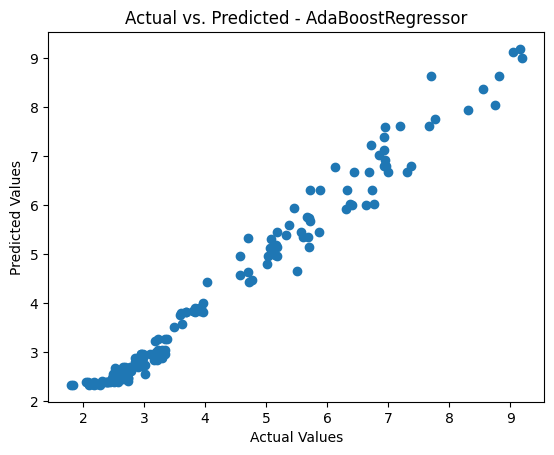

LinearRegression CV Scores: [-0.13912788 -0.12123817 -0.12168491 -0.11606169 -0.10106451]
LinearRegression Mean Squared Error (MSE): 0.12994396823248544
LinearRegression Root Mean Squared Error (RMSE): 0.3604774170908428
LinearRegression Mean Absolute Error (MAE): 0.26879926408336163
LinearRegression R^2 Score: 0.9626982329815239


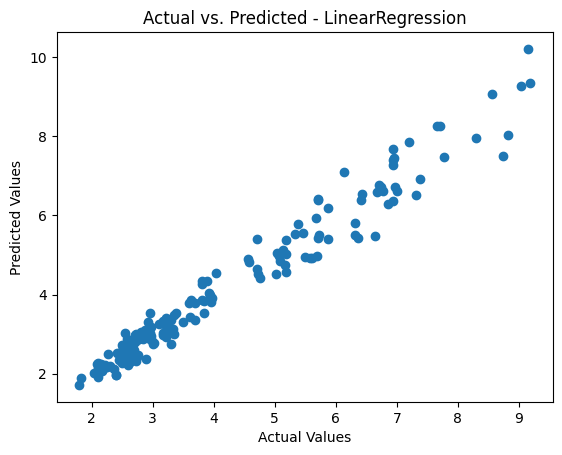

KNeighborsRegressor CV Scores: [-0.13084266 -0.15861639 -0.12258442 -0.10230701 -0.12328181]
KNeighborsRegressor Mean Squared Error (MSE): 0.12104335794285714
KNeighborsRegressor Root Mean Squared Error (RMSE): 0.34791285969744945
KNeighborsRegressor Mean Absolute Error (MAE): 0.25429142857142856
KNeighborsRegressor R^2 Score: 0.9652532456986357


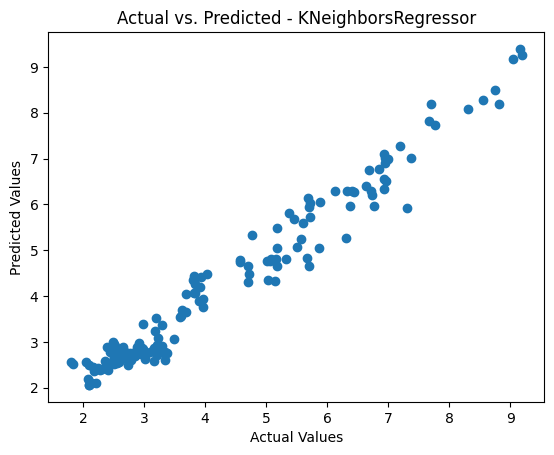

RandomForestRegressor CV Scores: [-0.09155642 -0.05141642 -0.04282161 -0.04712309 -0.05250337]
RandomForestRegressor Mean Squared Error (MSE): 0.05770171136000006
RandomForestRegressor Root Mean Squared Error (RMSE): 0.24021180520532304
RandomForestRegressor Mean Absolute Error (MAE): 0.1614156571428572
RandomForestRegressor R^2 Score: 0.9834361238694265


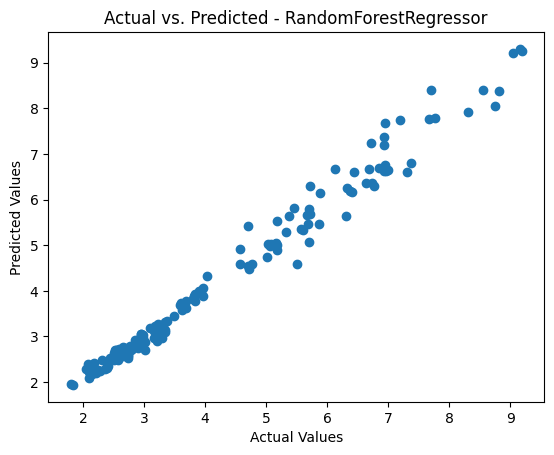

GradientBoostingRegressor CV Scores: [-0.10715311 -0.11293393 -0.08026519 -0.06894212 -0.07140419]
GradientBoostingRegressor Mean Squared Error (MSE): 0.09774285290100608
GradientBoostingRegressor Root Mean Squared Error (RMSE): 0.31263853393496793
GradientBoostingRegressor Mean Absolute Error (MAE): 0.21345780455814065
GradientBoostingRegressor R^2 Score: 0.9719418979100946


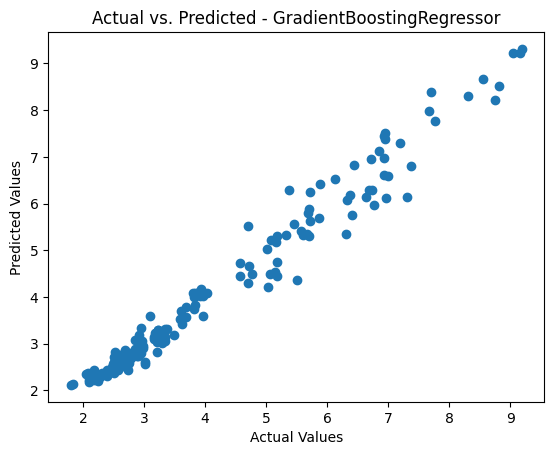

XGBRegressor CV Scores: [-0.09644888 -0.04749003 -0.04268919 -0.05470232 -0.05057248]
XGBRegressor Mean Squared Error (MSE): 0.05693222871260332
XGBRegressor Root Mean Squared Error (RMSE): 0.23860475417016175
XGBRegressor Mean Absolute Error (MAE): 0.1642663701629639
XGBRegressor R^2 Score: 0.9836570118631393


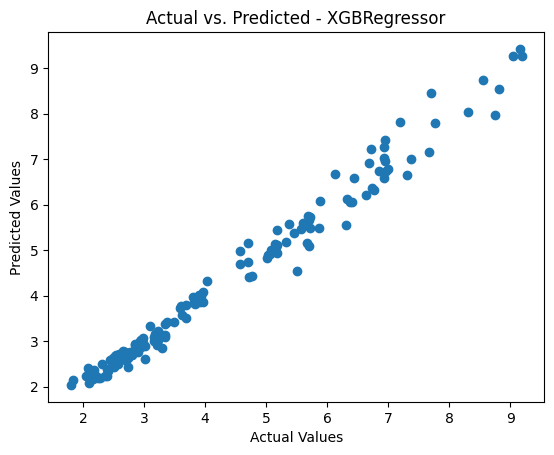

In [8]:
# Improved model evaluation and cross-validation for regression
model_results = []

# Looping through regression models and evaluating their performance
for name, model in regressors.items():
    try:
        logger.info(f"Training and evaluating {name} model.")
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

        # Model training
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        
        # Evaluation metrics for regression
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)

        model_results.append({'Model': name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R^2': r2, 'CV Scores': cv_scores})
        
        print("=============================================================================")
        print(name, "CV Scores:", cv_scores)
        print(name, "Mean Squared Error (MSE):", mse)
        print(name, "Root Mean Squared Error (RMSE):", rmse)
        print(name, "Mean Absolute Error (MAE):", mae)
        print(name, "R^2 Score:", r2)
        
        logger.info(f"{name} - CV Scores: {cv_scores}")
        logger.info(f"{name} - MSE: {mse}")
        logger.info(f"{name} - RMSE: {rmse}")
        logger.info(f"{name} - MAE: {mae}")
        logger.info(f"{name} - R^2 Score: {r2}")

        # Plotting the actual vs. predicted values
        plt.scatter(y_test, predictions)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'Actual vs. Predicted - {name}')
        plt.show()

    except Exception as ex:
        print(ex)
        logger.error(f"An error occurred while processing {name} model: {ex}")


## Model Results Baseline
- MSE is the one that we will use as MSE penalizes larger errors more heavily, which can be important in financial forecasting where large errors may have significant consequences.

In [9]:
df_results = pd.DataFrame(model_results)
df_results

,Model,MSE,RMSE,MAE,R^2,CV Scores
0,AdaBoostRegressor,0.071369,0.267150,0.194598,0.979513,"[-0.09757365678565265, -0.07629574743773948, -..."
1,LinearRegression,0.129944,0.360477,0.268799,0.962698,"[-0.13912787538723304, -0.12123816590345246, -..."
2,KNeighborsRegressor,0.121043,0.347913,0.254291,0.965253,"[-0.1308426617142857, -0.15861639228571425, -0..."
3,RandomForestRegressor,0.057702,0.240212,0.161416,0.983436,"[-0.09155642232928624, -0.051416419869285655, ..."
4,GradientBoostingRegressor,0.097743,0.312639,0.213458,0.971942,"[-0.10715311303273982, -0.11293392843381643, -..."
5,XGBRegressor,0.056932,0.238605,0.164266,0.983657,"[-0.09644888220756932, -0.04749003059306508, -..."


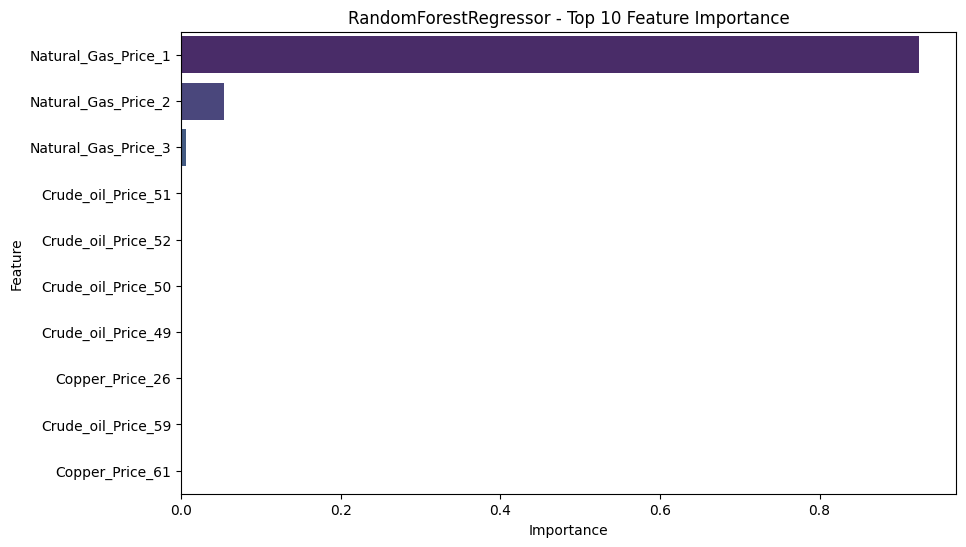

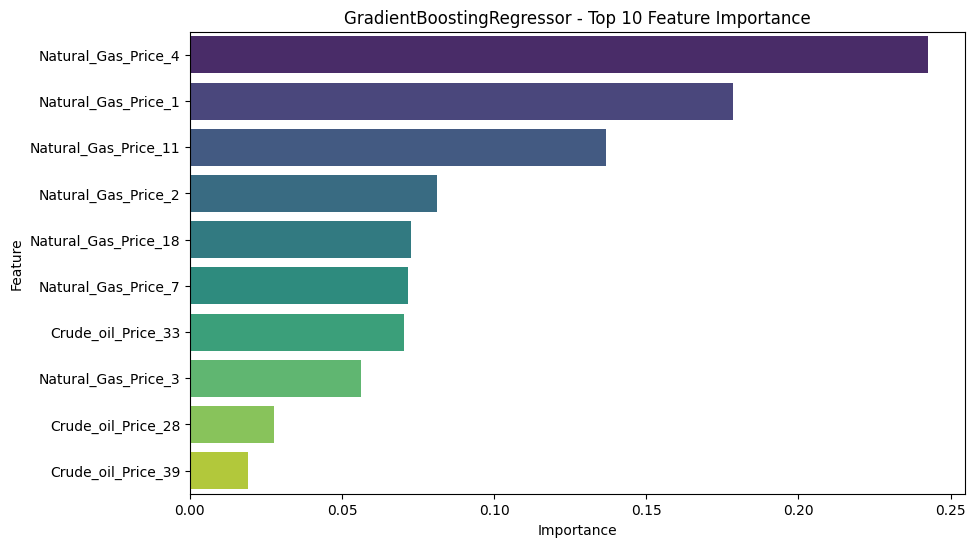

In [10]:
# Feature importance for tree-based models
for name, model in regressors.items():
    if isinstance(model, (RandomForestRegressor, GradientBoostingRegressor)):
        model.fit(X_train, y_train)
        feature_importances = model.feature_importances_
        feature_names = X_train.columns
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
        sorted_df = importance_df.sort_values(by='Importance', ascending=False)
        
        # Display only the top 10 features
        top_10_features = sorted_df.head(10)
        
        # Create seaborn bar plot for the top 10 features
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=top_10_features, palette='viridis')
        plt.title(f"{name} - Top 10 Feature Importance")
        plt.show()


## Big Model

In [11]:
# Define parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 10000,
    'max_depth': 1000,
    'num_iterations':500,
    'is_enable_sparse': 'true',
    'learning_rate': 0.001,
    'max_bin':10000,
    'max_drop': 1,
    'feature_fraction': 0.95
}

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'num_leaves': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'feature_fraction': [0.8, 0.9, 1.0],
    'device': ['gpu','cpu']  # You can add 'cpu' here to try both GPU and CPU
}

callbacks = [lgb.early_stopping(50)]
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

try:
    # Try using GPU
    params['device'] = 'gpu'    
    bst = lgb.train(params, train_data, valid_sets=[test_data], callbacks=callbacks)
except lgb.basic.LightGBMError as e:
    # GPU training not supported, fall back to CPU
    del params['device']
    bst = lgb.train(params, train_data, valid_sets=[test_data], callbacks=callbacks)

# Make predictions on the test set
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

 # Evaluation metrics for regression
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

model_results.append({'Model': name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R^2': r2, 'CV Scores': cv_scores})

print("=============================================================================")
print(name, "CV Scores:", cv_scores)
print(name, "Mean Squared Error (MSE):", mse)
print(name, "Root Mean Squared Error (RMSE):", rmse)
print(name, "Mean Absolute Error (MAE):", mae)
print(name, "R^2 Score:", r2)


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 79908
[LightGBM] [Info] Number of data points in the train set: 699, number of used features: 349
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 349 dense feature groups (0.23 MB) transferred to GPU in 0.002095 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 4.024584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [12]:
# Save log messages to a file
# File handling: close the FileHandler
file_handler.close()
logger.removeHandler(file_handler)